# Density estimation using normalizing flows

So far we have built a number of supervised machine learning methods for estimating the properties of individual haloes. These are typically fully deterministic - a given set of input features will produce a *single* output value. However, haloes with very similar properties can host very different galaxies, as a result of e.g. their assembly history. 

It would be useful to be able to generate galaxies with a range of *expected* properties, given some conditional input parameters. One method for doing this is using **density estimation**, where the probability density of a given parameter is modelled directly. A number of methods can be used to do this, many of which we will hear about over the coming weeks, such as Generative Adversarial Networks (GANs) and Variational Auto Encoders (VAEs). Another method for achieving this is using **Normalizing flows** (NF; see [Sultan's talk last week](https://online.kitp.ucsb.edu/online/galevo23/hassan/) for an example application to HI maps). Normalizing flows allow us to construct very flexible distributions, from which we can sample easily, and also rapidly evaluate the density.

In this short tutorial we will build a simple conditional NF model for the galaxy-halo relationship. This tutorial is based on more detailed ongoing work that will be on the arXiv soon - please reach out if you have any more detailed questions!

You can read more about NF in the following papers: Kobyzev, Prince & Brubaker 2019, [arXiv:1908.09257](https://arxiv.org/abs/1908.09257)

This section is heavily inspired by the [pyro docs on normalizing flows](https://pyro.ai/examples/normalizing_flows_i.html)



![an image](https://miro.medium.com/max/1400/1*wR6mfpyRY5Xbm5EPrLPNUw.webp)

### 7.1 Import PyTorch and Pyro

In [108]:
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import os
smoke_test = ('CI' in os.environ)

### 7.2 Some background

Take a multivariate normal distribution $X\sim\mathcal{N}(\mathbf{0},I_{D\times D})$. We can generate samples from a new distribution, $Y$, by passing this through a bijective (reversible) function $g(\cdot)$ (vector valued in the multivaraite case, $g:\mathbb{R}^D\rightarrow\mathbb{R}^D$), in order to produce a new transformed variable $Y=g(X)$. 

![norm flow](https://siboehm.com/assets/img/nfn/normalizing_flow.png)

We will typically want to **sample** from this new variable, and also apply **scoring** in order to evaluate the mapping we have learnt; how does the log density of $X$ relate to $Y$?

Sampling is simple - we first sample $X = x$, then $y=g(x)$.

For scoring, we can use the substitution rule. The expectation value of $X$ is given by

\begin{align}
\mathbb{E}_{p_X(\cdot)}\left[f(X)\right] &= \int_{\text{supp}(X)}f(\mathbf{x})p_X(\mathbf{x})d\mathbf{x}\\
&= \int_{\text{supp}(Y)}f(g^{-1}(\mathbf{y}))p_X(g^{-1}(\mathbf{y}))\det\left|\frac{d\mathbf{x}}{d\mathbf{y}}\right|d\mathbf{y}\\
&= \mathbb{E}_{p_Y(\cdot)}\left[f(g^{-1}(Y))\right],
\end{align}

Because $g$ is bijective we can go apply the substituion rule. Then, equating the last two lines

\begin{align}
\log(p_Y(y)) &= \log(p_X(g^{-1}(y)))+\log\left(\det\left|\frac{d\mathbf{x}}{d\mathbf{y}}\right|\right)\\
&= \log(p_X(g^{-1}(y)))-\log\left(\det\left|\frac{d\mathbf{y}}{d\mathbf{x}}\right|\right).
\end{align}

From the docs: "Inituitively, this equation says that the density of $Y$ is equal to the density at the corresponding point in $X$ plus a term that corrects for the warp in volume around an infinitesimally small length around $Y$ caused by the transformation. For instance, in 2-dimensions, the geometric interpretation of the absolute value of the determinant of a Jacobian is that it represents the area of a parallelogram with edges defined by the columns of the Jacobian. In $n$-dimensions, the geometric interpretation of the absolute value of the determinant Jacobian is that is represents the hyper-volume of a parallelepiped with edges defined by the columns of the Jacobian "

The 'flow' in normalising flows comes from the fact that we can combine these transformation linearly. Say we have transforms $g_{(0)}, g_{(1)},\ldots,g_{(L-1)}$, then the log density of the transformed variable, $Y=(g_{(0)}\circ g_{(1)}\circ\cdots\circ g_{(L-1)})(X)$, is

\begin{align}
\log(p_Y(y)) &= \log\left(p_X\left(\left(g_{(L-1)}^{-1}\circ\cdots\circ g_{(0)}^{-1}\right)\left(y\right)\right)\right)+\sum^{L-1}_{l=0}\log\left(\left|\frac{dg^{-1}_{(l)}(y_{(l)})}{dy'}\right|\right),
%\left( g^{(l)}(y^{(l)})
%\right).
\end{align}

Using this framework, we can transform simple i.i.d normal noise into much more complex distributions. 

### 7.3 A simple NF

Let's start with a simple single layer example of transforming a univariate unit gaussian.

\begin{align}
X &\sim \mathcal{N}(0,1)\\
Y &= \text{exp}(X).
\end{align}

First create our base distribution, `dist_x`, and the transform, `exp_transform`

In [110]:
dist_x = dist.Normal(torch.zeros(1), torch.ones(1))
exp_transform = T.ExpTransform()

We can then create a `TransformedDistribution`, `dist_y`, which takes as argument our base distribution and a list of transformations.

In [112]:
dist_y = dist.TransformedDistribution(dist_x, [exp_transform])

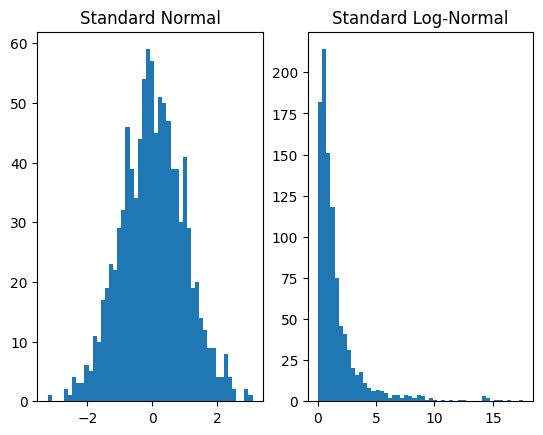

In [113]:
plt.subplot(1, 2, 1)
plt.hist(dist_x.sample([1000]).numpy(), bins=50)
plt.title('Standard Normal')
plt.subplot(1, 2, 2)
plt.hist(dist_y.sample([1000]).numpy(), bins=50)
plt.title('Standard Log-Normal')
plt.show()

To model more complex distributions we can compose transforms. Fro example, by combining an exponential with an affinbe transform we can reproduce the general log-normal (in this example with $\mu=3, \sigma=0.5$)

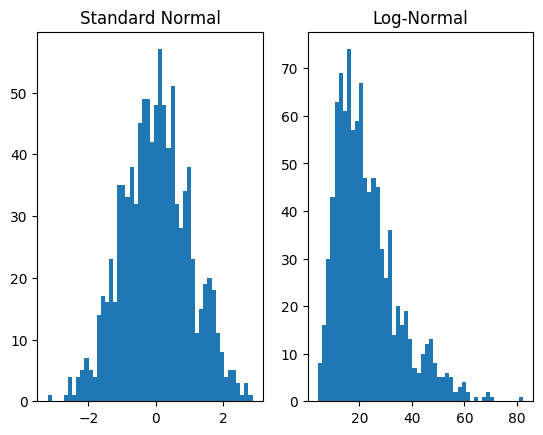

In [114]:
dist_x = dist.Normal(torch.zeros(1), torch.ones(1))
affine_transform = T.AffineTransform(loc=3, scale=0.5)
exp_transform = T.ExpTransform()
dist_y = dist.TransformedDistribution(dist_x, [affine_transform, exp_transform])

plt.subplot(1, 2, 1)
plt.hist(dist_x.sample([1000]).numpy(), bins=50)
plt.title('Standard Normal')
plt.subplot(1, 2, 2)
plt.hist(dist_y.sample([1000]).numpy(), bins=50)
plt.title('Log-Normal')
plt.show()

### 7.4 Multivariate transforms

So far we have considered univariate distributions. In the following we consider multivariate distributinos, in particular a simple example of two concentric circles.

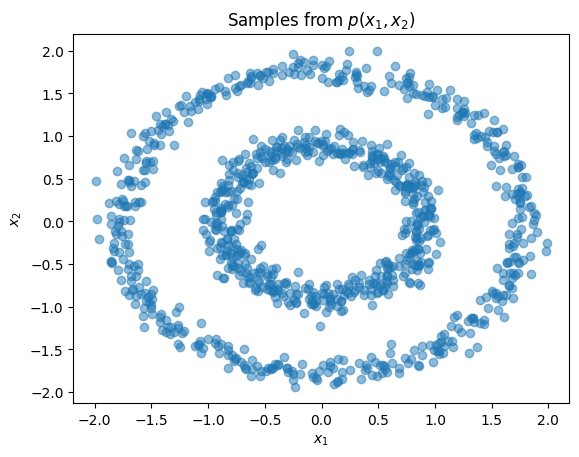

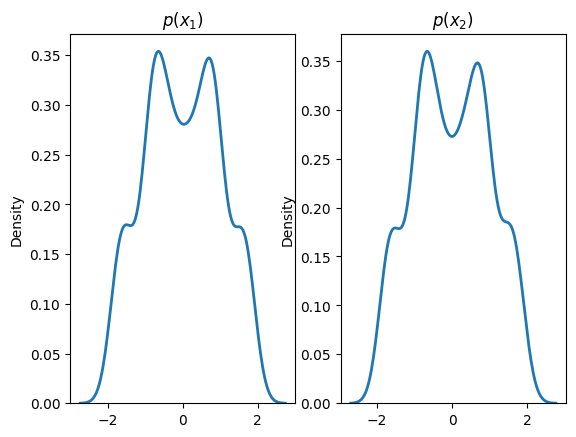

In [116]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

n_samples = 1000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X = StandardScaler().fit_transform(X)

plt.title(r'Samples from $p(x_1,x_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_2)$')
plt.show()

We can learn the marginals of this distribution using our existing machinery, but this time considering a `Spline` transform (a monotonically increasing function).

In [117]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.Spline(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

To fit this model we use stochastic gradient descent on our maximum likelihood objective function, defined below (don't worry too much about the details here)

In [118]:
# %%time
steps = 1 if smoke_test else 1001
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-2)
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 3.716935396194458
step: 200, loss: 1.32396399974823
step: 400, loss: 1.28557550907135
step: 600, loss: 1.2757624387741089
step: 800, loss: 1.2703787088394165
step: 1000, loss: 1.2655694484710693


We can now plot samples from our learned flow

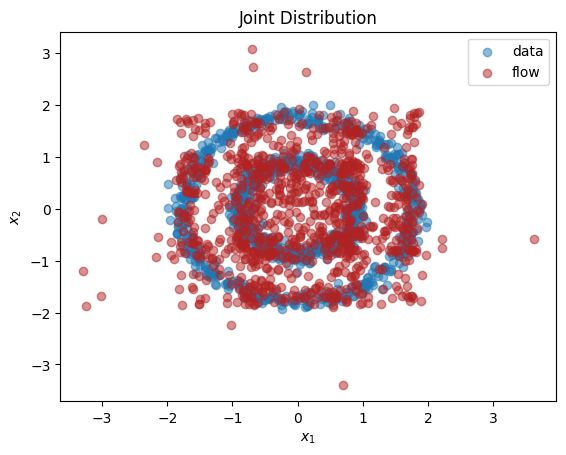

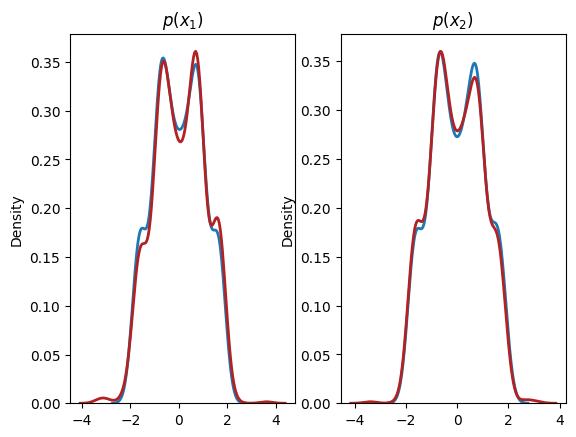

In [120]:
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()

It's clear that the marginals have been recovered very well, but the joint distribution has not.

To overcome this limitation we now implement coupled transforms. A coupled transform takes the input and divides it into dependent and conditional parts, then applies a bijective transform to the dependent input. 

\begin{align}
\mathbf{y}_{1:d} &= g_\theta(\mathbf{x}_{1:d})\\
\mathbf{y}_{(d+1):D} &= h_\phi(\mathbf{x}_{(d+1):D};\mathbf{x}_{1:d}),
\end{align}

This transform is then invertible in two stages

\begin{align}
\mathbf{x}_{1:d} &= g_\theta^{-1}(\mathbf{y}_{1:d})\\
\mathbf{x}_{(d+1):D} &= h_\phi^{-1}(\mathbf{y}_{(d+1):D};\mathbf{x}_{1:d}).
\end{align}

$g$ and $h$ represent different types of coupling transforms. Introducing different splines between different variables allows the model to represent complex conditional dependence in multivariate distributions.

To demonstrate, we use a `spline_coupling` layer

In [122]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.spline_coupling(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

In [123]:
# %%time
steps = 1 if smoke_test else 5001
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 4.4050164222717285
step: 500, loss: 1.97963547706604
step: 1000, loss: 1.8918458223342896
step: 1500, loss: 1.9247591495513916
step: 2000, loss: 1.7651989459991455
step: 2500, loss: 1.7568111419677734
step: 3000, loss: 1.7417011260986328
step: 3500, loss: 1.7819277048110962
step: 4000, loss: 1.7453879117965698
step: 4500, loss: 1.7875745296478271
step: 5000, loss: 1.7310254573822021
CPU times: user 2min 59s, sys: 0 ns, total: 2min 59s
Wall time: 44.9 s


In [ ]:
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()

Now, not only have re reproduced the marignals but the joint distribution as well.